# SARSA

In [4]:
#### Imports
from typing import Dict, List, Tuple, Optional
from collections import namedtuple
import pandas as pd
import numpy as np
import os

In [5]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')
import matplotlib.pyplot as plt        
plt.rcParams['figure.figsize'] = [15, 8]

In [6]:
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

# Qlearn

I found best parameters by interating over possible values of `learning rate`, `epsilon` and `discount factor`

In [2]:
def to_pandas(aggregate,trial:int):
    if type(aggregate) == list:
        aggregate = seq(aggregate)
    
    d = aggregate.to_pandas(columns= ['params','iteration','reward'])
    d['moving_avg'] = d.reward.rolling(window= 10).mean()
    d['trial'] = trial
    return d

In [7]:
def build_df_sarsa(trials:int) -> List[Tuple[str,pd.DataFrame]]: # [params,Df]
    
    builder = []
    
    for trial in trials:
        t = pd.read_csv(f"sarsa_{trial}.csv") 
#         t['moving_avg'] = t.rolling(window=10).mean()
        
        res = seq(t).group_by(lambda x:x[0])\
        .map(lambda prams_df: to_pandas(prams_df[1],trial).dropna()).to_list()
        
        builder = builder + res
    
    return builder

In [6]:
list(range(1,6))

[1, 2, 3, 4, 5]

In [8]:
dfs = build_df_sarsa(range(1,6))

In [9]:
def create_avgs(df_for_param:pd.DataFrame) -> Tuple[str,pd.DataFrame]:
    
    
    params = df_for_param.params.iloc[0]
    
    df_for_param = df_for_param[['iteration', 'moving_avg']].groupby(['iteration'],as_index=False).agg(['mean','std']).reset_index()
    df_for_param['mean'] = df_for_param['moving_avg','mean']
    df_for_param['std'] = df_for_param['moving_avg','std']
    df_for_param = df_for_param.drop(columns= 'moving_avg')
    return params, df_for_param
    
#     to_plot = d.copy()
#     to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
#     to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    

In [10]:
dfseq = seq(dfs)\
.group_by(lambda frame: frame.params.iloc[0])\
.map(lambda x: pd.concat(x[1])).cache()

In [11]:
avgs = dfseq.map(create_avgs).cache()

/home/owner/.local/lib/python3.8/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [31]:
def save_df(name : int, params: str, d:pd.DataFrame) :
    d.to_csv('./cache/' + str(name) + '.csv',index=False)
    with open('./cache/' + str(name), 'w') as f:
        f.write(params)

def load_df(name:int) -> Tuple[str,pd.DataFrame]:
    d = pd.read_csv('./cache' + str(name) + '.csv')
    with open('./cache/' + str(name)) as f:
        params = f.read()
    return p,d

In [12]:
avgs.zip_with_index().for_each(lambda pram_df_i: save_df(pram_df_i[1],pram_df_i[0][0],pram_df_i[0][1]))

In [24]:
# dfs = seq(df).group_by(lambda x: x[0])\
# .map(lambda x:
#      (x[0],
#       create_avgs(seq(x[1])\
#                   .to_pandas(columns=["params","iteration","reward","moving_avg","trial"])))
#     )

In [13]:
maxes = avgs.order_by(lambda x: - x[1]['mean'].iloc[:-100].mean()).take(n=10).cache()

In [14]:
maxes.map(lambda x: x[1]['mean'].max())

[83.14, 51.9, 45.1, 48.540000000000006, 42.5, 38.48, 38.42, 35.279999999999994, 40.50000000000001, 48.7]

In [15]:
def present(x:Tuple[str,pd.DataFrame]):
    to_plot = x[1].copy()
    to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
    to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    
    to_plot = to_plot[['mean','plus_std','minus_std']]
#     display(HTML(x[0]))

    title=x[0]
    t = title.split("|")
    if float(t[-1]) > 1:
        bucket = t[-1][0]
        decay = t[-1][1:]
        t= t[:-1] + [bucket,decay]
        title = "|".join(t)

    to_plot.plot(title= title)

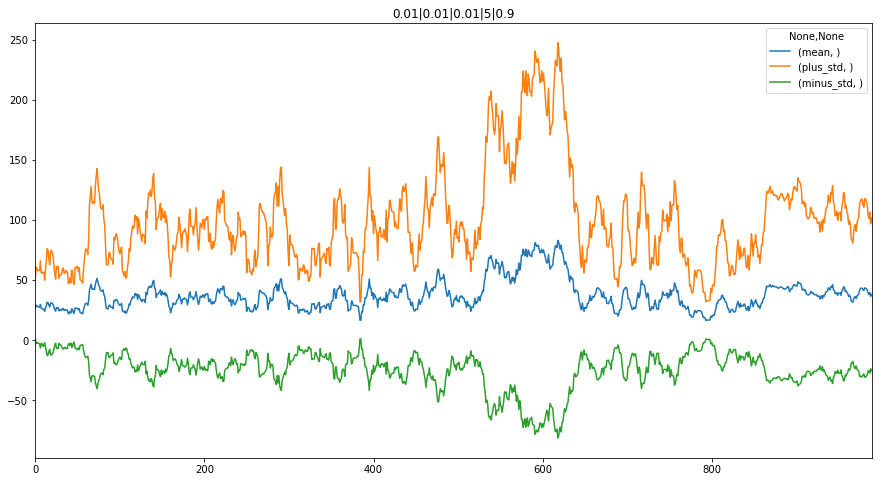

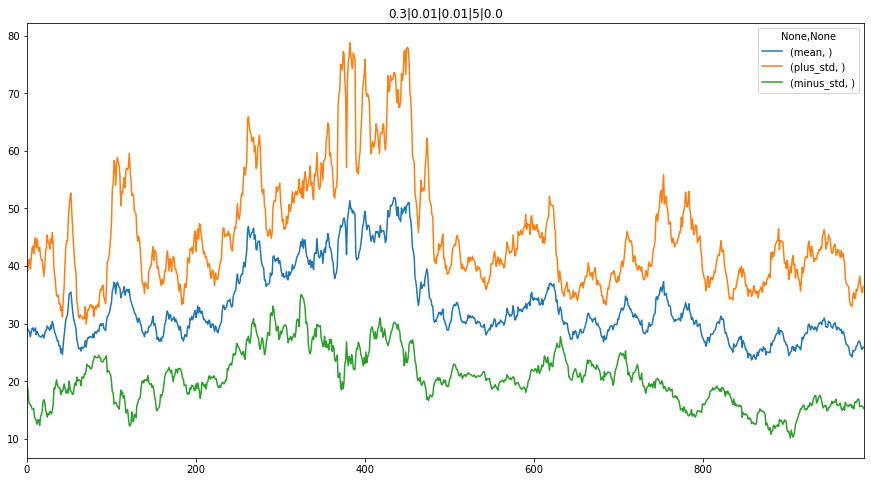

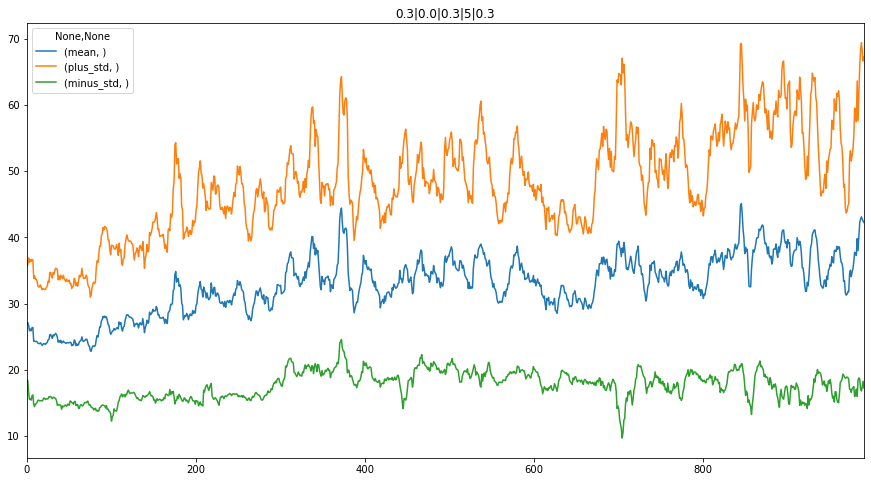

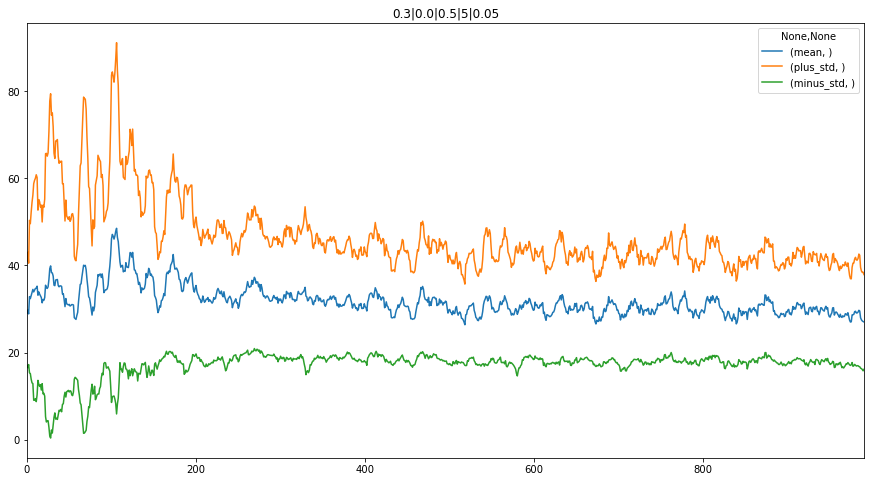

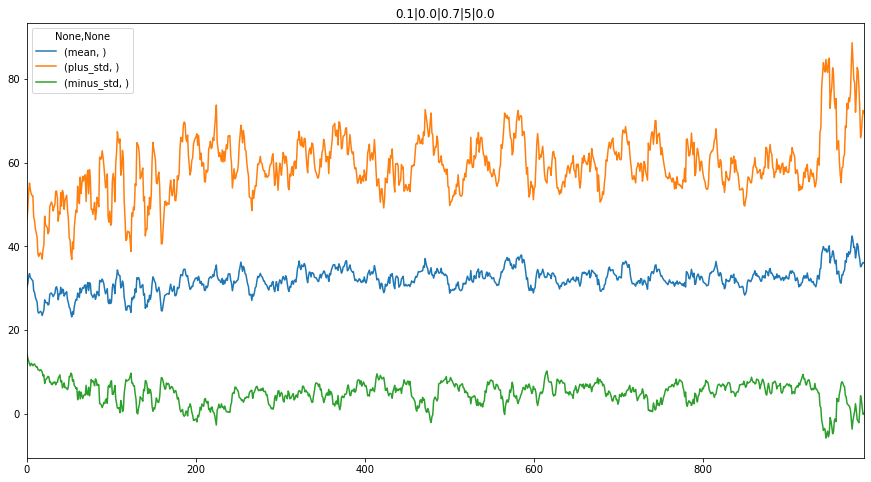

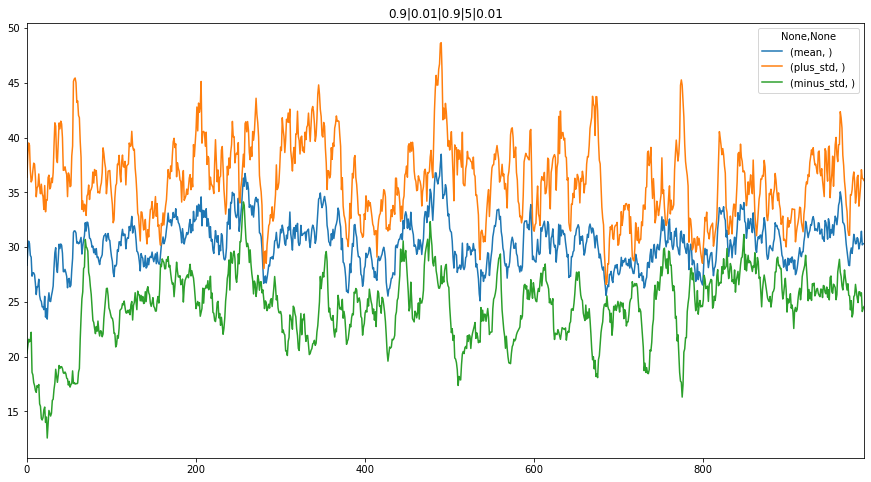

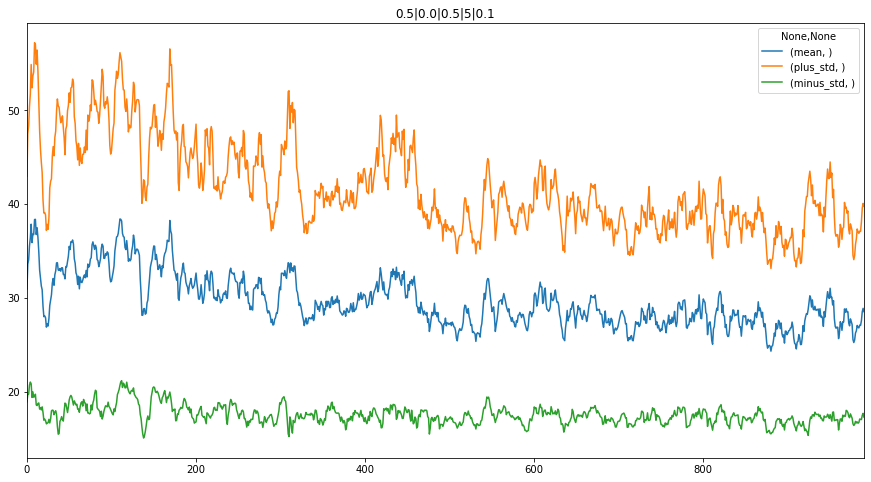

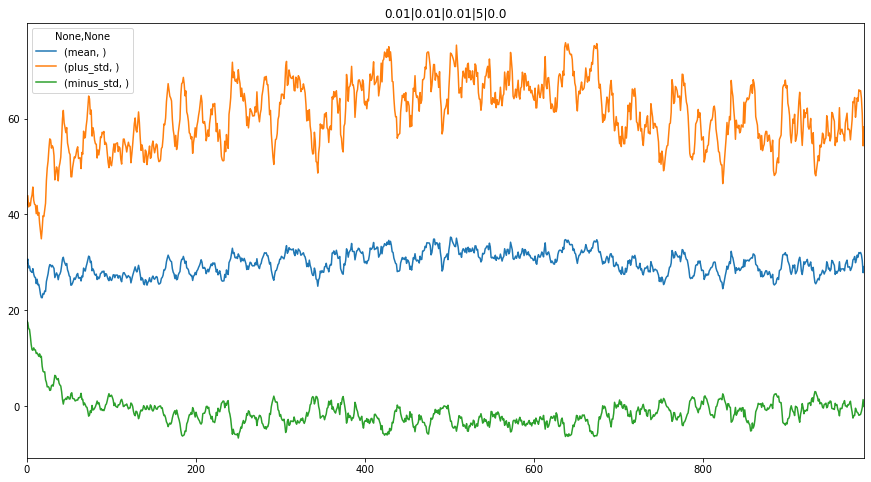

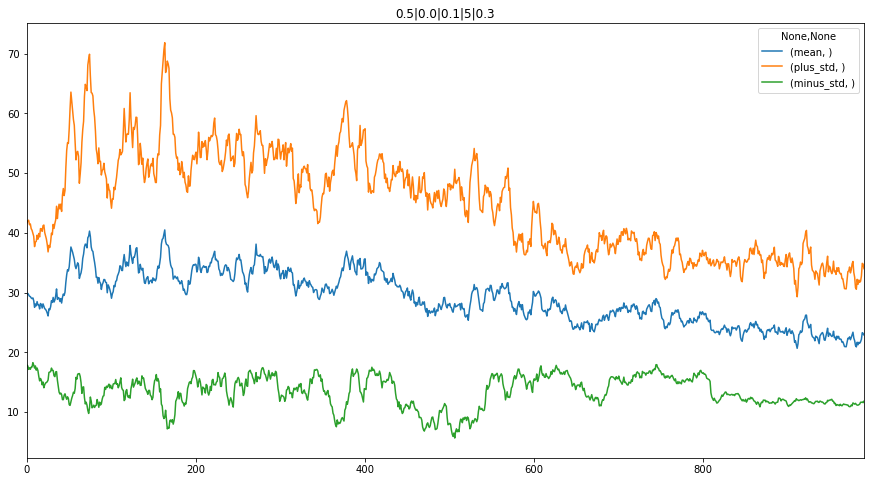

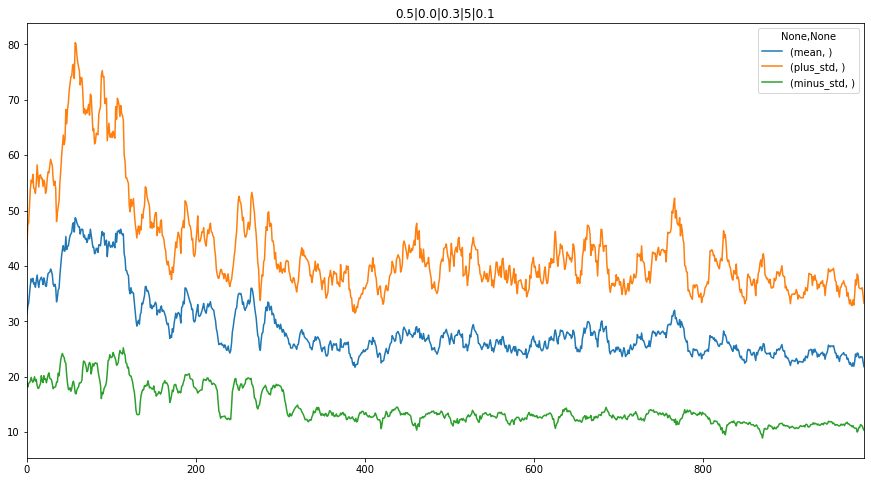

In [16]:
maxes.for_each(present)

0.2 0.1 0.7 4

0.2 0.1 0.7 4

In [6]:
#display(HTML("<h3>LearningRate | eps | discount_factor | buckets</h3>"))
#maxes.for_each(present)

## Longer runs

In [ ]:
0.8 0.9 0.9 4 0.25
0.6 0.9 0.9 4 0.25
0.5 0.5 0.8 4 0.25
0.4 0.6 0.9 4 0.25

In [48]:
%%sh
for  i in $(seq 1 6);do
    cat chosen_${i}.csv | awk '/reward/{if(NR ==1){print $0}; next} {print}' > chosen_fix_${i}.csv
done

In [17]:
def build_choosen(trials) -> pd.DataFrame:
    
    builder = []
    
    for trial in trials:
#         t = pd.read_csv(f"chosen_fix_{trial}.csv") 
        t = pd.read_csv(f"chosen_sarsa_{trial}.csv") 
#         t['moving_avg'] = t.rolling(window=10).mean()
        
        res = seq(t).group_by(lambda x:x[0])\
        .map(lambda prams_df: to_pandas(prams_df[1],trial).dropna()).to_list()
        
        builder = builder + res
    
    return pd.concat(builder) 

In [19]:

chosen_df= build_choosen([1])
chosen = seq(build_choosen(trials))\
.group_by(lambda x: x[0])\
.map(lambda x: 
     (
         x[0],
         create_avgs(seq(x[1]).to_pandas(columns=["params","iteration","reward","moving_avg","trial"]))
     )
    )

FileNotFoundError: [Errno 2] File b'chosen_sarsa_1.csv' does not exist: b'chosen_sarsa_1.csv'